# Project: Customer Clusterization

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
sns.set_theme()

# Data Preparation

In [2]:
df1 = pd.read_csv("data.csv", low_memory=False)

In [3]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice       object
CustomerID     float64
Country         object
dtype: object

In [5]:
df1["Country"].value_counts().head()

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64

In [6]:
# Since the UK is by far the most common country, we'll be working only with UK customers for now
df1 = df1.copy()[df1["Country"] == "United Kingdom"]

In [7]:
# We'll filter out customers with a negative quantity of purchase
df1 = df1[df1["Quantity"] > 0]

In [8]:
# Filtering any order without a customer ID
df1 = df1.dropna(axis="index", subset=["CustomerID"])

In [9]:
# Drop columns that won't be used in this analysis.
df1 = df1.drop(columns=["Description", "StockCode", "Country"])

In [10]:
df1["InvoiceNo"] = df1["InvoiceNo"].astype(int)
df1["InvoiceDate"] = df1["InvoiceDate"].astype("datetime64")
df1["UnitPrice"] = df1["UnitPrice"].str.replace(pat=",", repl="") # Remove the thousands separator
df1["UnitPrice"] = df1["UnitPrice"].astype(float)
df1["CustomerID"] = df1["CustomerID"].astype(int)

In [11]:
df1.dtypes

InvoiceNo               int64
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
dtype: object

# Exploratory Data Analysis

In [12]:
df1.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,354345.000000,354345.000000,354345.000000,354345.000000
mean,560672.612341,12.048913,2.963793,15552.436219
std,13168.988616,190.428127,17.862067,1594.546025
min,536365.000000,1.000000,0.000000,12346.000000
25%,549241.000000,2.000000,1.250000,14194.000000
50%,561900.000000,4.000000,1.950000,15522.000000
75%,572295.000000,12.000000,3.750000,16931.000000
max,581586.000000,80995.000000,8142.750000,18287.000000


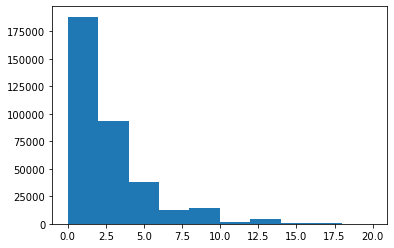

In [13]:
plt.hist(df1["UnitPrice"][ df1["UnitPrice"] < 20 ]);

In [14]:
count1 = df1["InvoiceNo"][df1["UnitPrice"] < 20].count()
count2 = df1["InvoiceNo"].count()
print(f"{count1} out of {count2} purchases were under $20, or {count1/count2:.2%} of the total.")

353678 out of 354345 purchases were under $20, or 99.81% of the total.


The vast majority of the purchases made on this database were of small value, as seen on the histogram.

In [15]:
df1["CustomerID"].value_counts().median()

41.0

In [16]:
count1 = (df1["CustomerID"].value_counts()>50).sum()
count2 = df1["CustomerID"].nunique()
print(f"{count1} out of {count2} customers made more than 50 purchases, or {count1/count2:.2%} of the total.")

1713 out of 3921 customers made more than 50 purchases, or 43.69% of the total.


In contrast, there's a a more even distribution of number of purchases, with many customers having made over 50 purchases in total.

# Feature Engineering

We'll create a new dataframe where each row represents a customer.

In [17]:
df2 = pd.DataFrame(df1["CustomerID"].unique(), columns=["CustomerID"])

The first feature we'll introduce is the *Total Revenue*, the sum of all the purchases the customer made so far. 

In [18]:
# First, we sum the amount of money spent on each purchase
df1["Subtotal"] = df1["Quantity"] * df1["UnitPrice"]
# Then we group the purchases from each customer and add it to the customer dataframe
aux = df1[["CustomerID", "Subtotal"]].groupby("CustomerID").sum().reset_index()
aux.columns=["CustomerID","TotalRevenue"]
if "TotalRevenue" in df2.columns:
    df2 = df2.drop(columns=["TotalRevenue"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

Another feature will be *Recency*, that is, the time since the last purchase.

In [19]:
# First, we'll use the last invoice date as the current time
curr_time = df1["InvoiceDate"].max()
df1["Recency"] = (curr_time - df1["InvoiceDate"]).dt.days
# Then the data for each customer is added to the dataframe
aux = df1[["Recency", "CustomerID"]].groupby("CustomerID").min().reset_index()
if "Recency" in df2.columns:
    df2 = df2.drop(columns=["Recency"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

Finally, *Frequency* will be the total amount of purchases the customer made during the recorded period.

In [23]:
aux = df1[["CustomerID", "InvoiceNo"]].groupby("CustomerID").nunique().reset_index()
aux.columns = ["CustomerID", "Frequency"]
if "Frequency" in df2.columns:
    df2 = df2.drop(columns=["Frequency"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

We will use those features for now. The shape of the data can be visualized, so that we can see if it needs to be scaled or remapped.

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

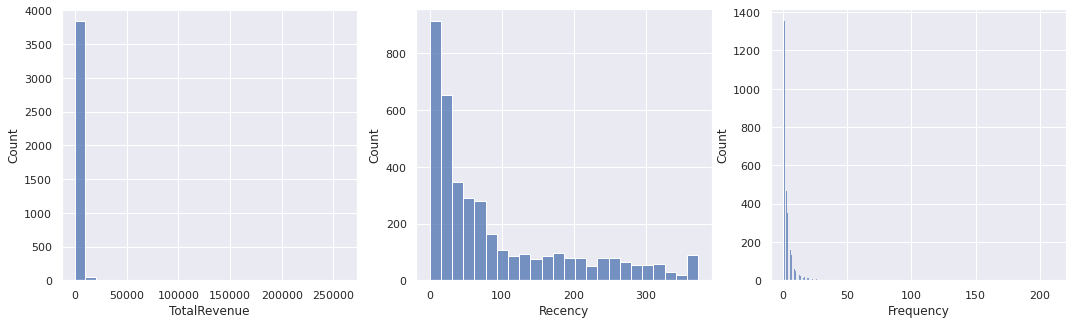

In [38]:
fig, ax = plt.subplots(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
sns.histplot(df2["TotalRevenue"], binwidth=10000, ax=ax1)
ax2 = plt.subplot(1,3,2)
sns.histplot(df2["Recency"], ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.histplot(df2["Frequency"], ax=ax3)